# <Span style = 'color: #008B8B'> Data Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#NLP library 
import re
import unicodedata
import nltk
from wordcloud import WordCloud


from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.tokenize.toktok import ToktokTokenizer

#My libraries 
import acquire as a 
from env import user, password, hostname


#Beautiful Soup and Webscrape
from requests import get
from bs4 import BeautifulSoup


## <Span style = 'color: #008B8B'>ACQUIRE 
### <span style = 'color: purple'>1.Spam Data

#### a. Load the spam data set.

In [2]:
def get_connection(db_name, host=hostname, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{hostname}/{db_name}'


url = get_connection("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

,label,text
id,,
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## <Span style = 'color: #008B8B'> PREPARE

In [3]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [4]:
#Value counts of labels
df['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [5]:
#Example of text
df.iloc[1].text

'Ok lar... Joking wif u oni...'

In [6]:
#Ham vs Spam

labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels

,n,percent
ham,4825,0.865937
spam,747,0.134063


In [7]:
# Ham vs Spam function
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


,n,percent
ham,4825,0.865937
spam,747,0.134063


Break the data up into 3 seperate pieces:

- The words that appear in legitimate text messages.
- The words that appear in spam text messages.
- All of the words.


In [8]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


## <Span style = 'color: #008B8B'> EXPLORE SPAM DATA

#### b. Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?
Is there any overlap in the bigrams for the spam data and the ham data?

In [9]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()

call    359
free    216
txt     150
ur      144
text    137
dtype: int64

In [10]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()



(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
dtype: int64

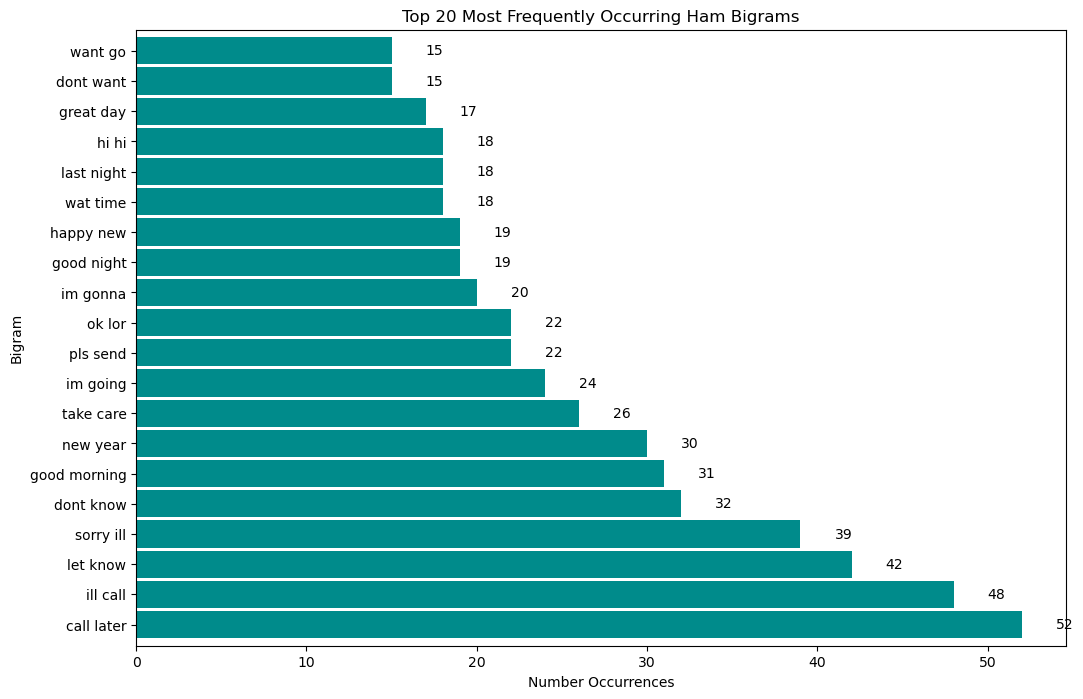

In [11]:
# Sort the bigrams in descending order by frequency
top_20_ham_bigrams = top_20_ham_bigrams.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
bars = top_20_ham_bigrams.plot(kind='barh', color = '#008B8B', width=0.9)

# Add count annotations at the end of the bars
for bar in bars.patches:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, 
             f'{int(bar.get_width())}', 
             va='center', ha='left', fontsize=10, color='black')

plt.title('Top 20 Most Frequently Occurring Ham Bigrams')
plt.xlabel('Number Occurrences')
plt.ylabel('Bigram')

# Make the labels pretty
ticks, labels = plt.yticks()
new_labels = [f'{bigram[0]} {bigram[1]}' for bigram in top_20_ham_bigrams.index]
plt.yticks(ticks, new_labels)

plt.show()


#### BIGRAM WORD CLOUD

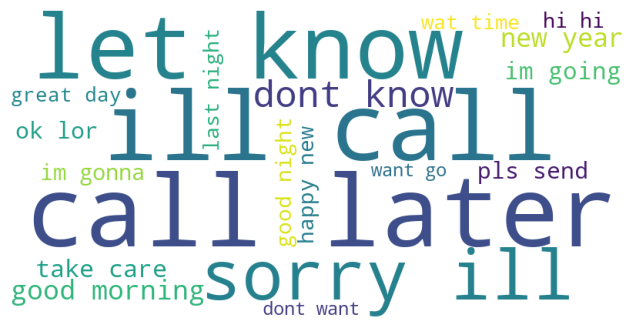

In [12]:

data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


### The barplot and word cloud are similar. Showing 'call later','ill call' and 'let know' as the most frequent

# <Span style = 'color: #008B8B'> CODEUP BLOG 

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.

In [13]:
url = 'https://codeup.edu/blog/'
headers = {'User-Agent': 'Codeup Data Science'}
response = get(url, headers=headers)

soup = BeautifulSoup(response.content, 'html.parser')

links = [link['href'] for link in soup.select('.more-link')]

articles = []

for url in links:
    
    url_response = get(url, headers=headers)
    soup = BeautifulSoup(url_response.text)
    
    title = soup.find('h1', class_='entry-title').text
    content = soup.find('div', class_='entry-content').text.strip()
    
    article_dict = {
        'title': title,
        'content': content
    }
    
    articles.append(article_dict)

In [14]:
blog_df = pd.DataFrame(articles)
blog_df

,title,content
0,Spotlight on APIDA Voices: Celebrating Heritag...,May is traditionally known as Asian American a...
1,Women in tech: Panelist Spotlight – Magdalena ...,Women in tech: Panelist Spotlight – Magdalena ...
2,Women in tech: Panelist Spotlight – Rachel Rob...,Women in tech: Panelist Spotlight – Rachel Rob...
3,Women in Tech: Panelist Spotlight – Sarah Mellor,Women in tech: Panelist Spotlight – Sarah Mell...
4,Women in Tech: Panelist Spotlight – Madeleine ...,Women in tech: Panelist Spotlight – Madeleine ...
5,Black Excellence in Tech: Panelist Spotlight –...,Black excellence in tech: Panelist Spotlight –...


In [15]:
blog_df.to_csv('blog_articles.csv', index=False)

In [16]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']
def clean_blog(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [17]:

blog_df['cleaned_content'] = blog_df['content'].apply(clean_blog)


In [18]:
#Value counts of labels
blog_df['title'].value_counts()

Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa    1
Women in tech: Panelist Spotlight – Magdalena Rahn                                        1
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill                                1
Women in Tech: Panelist Spotlight – Sarah Mellor                                          1
Women in Tech: Panelist Spotlight – Madeleine Capper                                      1
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia                  1
Name: title, dtype: int64

In [19]:

#Ham vs Spam for title

title_labels = pd.concat([blog_df.title.value_counts(),
                    blog_df.title.value_counts(normalize=True)], axis=1)
title_labels.columns = ['n', 'percent']
title_labels

,n,percent
Spotlight on APIDA Voices: Celebrating Heritage and Inspiring Change ft. Arbeena Thapa,1,0.166667
Women in tech: Panelist Spotlight – Magdalena Rahn,1,0.166667
Women in tech: Panelist Spotlight – Rachel Robbins-Mayhill,1,0.166667
Women in Tech: Panelist Spotlight – Sarah Mellor,1,0.166667
Women in Tech: Panelist Spotlight – Madeleine Capper,1,0.166667
Black Excellence in Tech: Panelist Spotlight – Wilmarie De La Cruz Mejia,1,0.166667


In [20]:
blog_df['content'] = blog_df['content'].str.lower()

In [21]:

#Ham vs Spam for content

content_labels = pd.concat([blog_df.content.value_counts(),
                    blog_df.content.value_counts(normalize=True)], axis=1)

content_labels.head()

content   content
may is traditionally known as asian american an...        1  0.166667
women in tech: panelist spotlight – magdalena r...        1  0.166667
women in tech: panelist spotlight – rachel robb...        1  0.166667
women in tech: panelist spotlight – sarah mello...        1  0.166667
women in tech: panelist spotlight – madeleine c...        1  0.166667

In [22]:
# remove anything that is not a through z, a number, a single quote, or whitespace
cleaned_labels = [re.sub(r"[^a-z0-9'\s]", '', content) for label in content_labels]




In [23]:
cleaned_labels[0:500]

['lack excellence in tech anelist potlight  ilmarie e a ruz ejia\n\nodeup is hosting a lack xcellence in ech anel in honor of lack istory onth on ebruary 22 2023 o further celebrate wed like to spotlight each of our panelists leading up to the discussion to learn a bit about their respective experiences as black leaders in the tech industry\xa0\xa0\neet ilmarie\nilmarie e\xa0a ruz ejia is a current odeup student on the path to becoming a ulltack eb eveloper at our allas  campus\xa0\nilmarie is a veteran expanding her knowledge of programming languages and technologies on her journey with odeup\xa0\ne asked ilmarie to share more about her experience at odeup he shares  was able to meet other people who were passionate about coding and be in a positive learning environment\ne hope you can join us on ebruary 22nd to sit in on an insightful conversation with ilmarie and all of our panelists',
 'lack excellence in tech anelist potlight  ilmarie e a ruz ejia\n\nodeup is hosting a lack xcelle

In [24]:
cleaned_labels = [unicodedata.normalize('NFKD', label).encode('ascii', 'ignore').decode('utf-8', 'ignore') for label in cleaned_labels]


In [25]:
#tokenize the words

tokenizer = nltk.tokenize.ToktokTokenizer()

print(tokenizer.tokenize(cleaned_labels, return_str=True)[0:500])

[ ' lack excellence in tech anelist potlight ilmarie e a ruz ejia\n\nodeup is hosting a lack xcellence in ech anel in honor of lack istory onth on ebruary 22 2023 o further celebrate wed like to spotlight each of our panelists leading up to the discussion to learn a bit about their respective experiences as black leaders in the tech industry \neet ilmarie\nilmarie e a ruz ejia is a current odeup student on the path to becoming a ulltack eb eveloper at our allas campus \nilmarie is a veteran expa


In [26]:
# Create the nltk stemmer object, then use it
ps = nltk.porter.PorterStemmer()

ps.stem('women'), ps.stem('code'), ps.stem('tech')

('women', 'code', 'tech')

In [27]:
# stems = [ps.stem(word) for word in cleaned_labels.split()]
# # article_stemmed = ' '.join(stems)
# # article_stemmed

lack excellence in tech anelist potlight ilmarie e a ruz ejia

odeup is hosting a lack xcellence in ech anel in honor of lack istory onth on ebruary 22 2023 o further celebrate wed like to spotlight each of our panelists leading up to the discussion to learn a bit about their respective experiences as black leaders in the tech industry 
eet ilmarie
ilmarie e a ruz ejia is a current odeup student on the path to becoming a ulltack eb eveloper at our allas campus 
ilmarie is a veteran expanding her


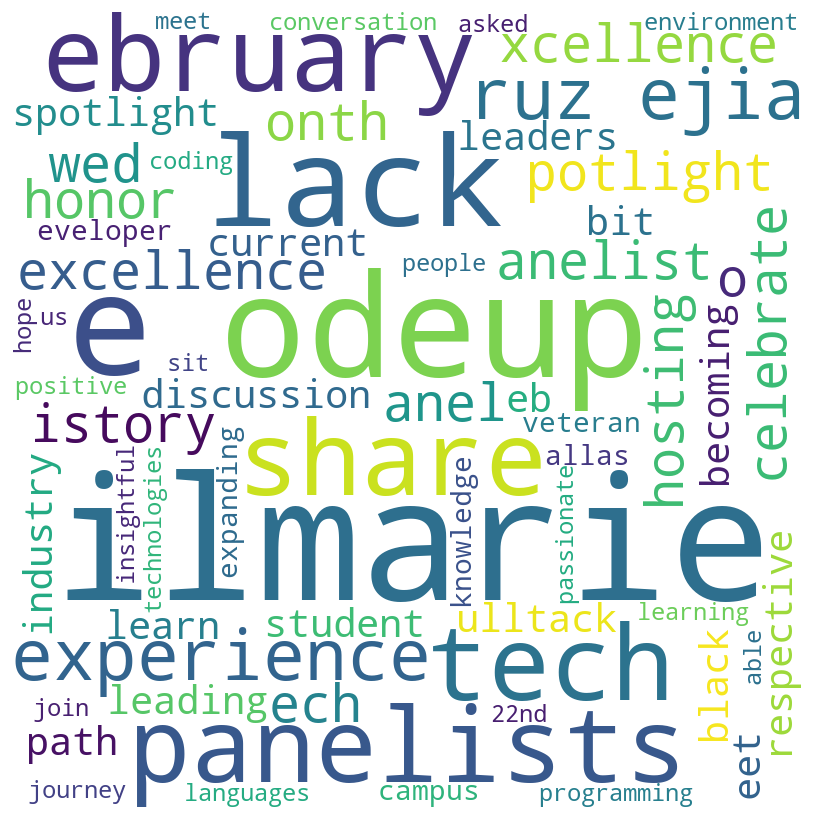

In [37]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Initialize the ToktokTokenizer
tokenizer = ToktokTokenizer()

# Tokenize the cleaned labels
tokens = tokenizer.tokenize(' '.join(cleaned_labels), return_str=True)

# Display the first 500 tokens
print(tokens[:500])

# Create a WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(tokens)

# Display the WordCloud using matplotlib
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [35]:
import nltk
import pandas as pd
from nltk.util import ngrams
from nltk.tokenize.toktok import ToktokTokenizer


# Initialize the ToktokTokenizer
tokenizer = ToktokTokenizer()

# Tokenize the cleaned labels
tokens = tokenizer.tokenize(' '.join(cleaned_labels))

# Get unigrams (individual words)
unigrams = list(ngrams(tokens, 1))

# Convert the list of unigrams to a pandas DataFrame
unigrams_df = pd.DataFrame(unigrams, columns=['unigram'])

# Get the top 500 most common unigrams
top_20_unigrams = unigrams_df['unigram'].value_counts().head(20)

print(top_20_unigrams)


a            16
to           14
in           12
ilmarie      12
on           10
of            8
e             8
odeup         8
her           6
our           6
about         6
the           6
and           6
lack          6
is            6
ejia          4
panelists     4
tech          4
ruz           4
ebruary       4
Name: unigram, dtype: int64


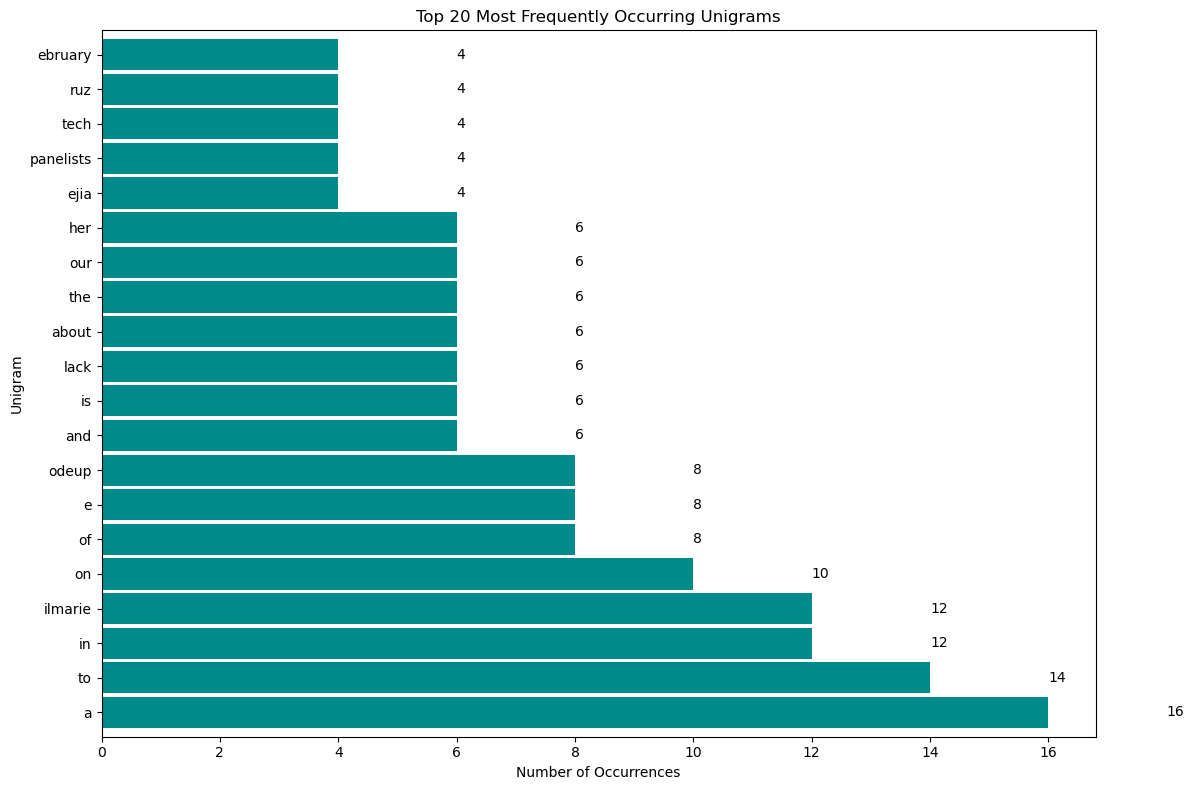

In [36]:
import matplotlib.pyplot as plt

# Sample top 20 most frequent unigrams (for demonstration purposes)
top_20_unigrams = top_20_unigrams.sort_values(ascending=False)

# Create the horizontal bar plot
plt.figure(figsize=(12, 8))
bars = top_20_unigrams.plot(kind='barh', color='#008B8B', width=0.9)

# Add count annotations at the end of the bars
for bar in bars.patches:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2,
             f'{int(bar.get_width())}',
             va='center', ha='left', fontsize=10, color='black')

plt.title('Top 20 Most Frequently Occurring Unigrams')
plt.xlabel('Number of Occurrences')
plt.ylabel('Unigram')

# Make the labels pretty
ticks, labels = plt.yticks()
new_labels = top_20_unigrams.index  # Using the unigram labels
plt.yticks(ticks, new_labels)

plt.tight_layout()  # To prevent label cutoff
plt.show()


#### The word cloud was a bit off as it shows 'to' 'a' were removed when we cleansed the data so 'e' 'il marie'and 'odeup' were most frequent

### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.